In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from cluster import StationCluster
import parameter
import pandas as pd
import simplejson
import pickle
from cluster_model import ClusterModel
from datetime import timedelta

In [4]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

with open('../station_information.json', 'r') as f:
    station_information = simplejson.load(f)['data']['stations']
    
model = ClusterModel(station_data=station_data)
model_2 = ClusterModel(station_data=station_data)

36 horizontal squares and 51 vertical squares. Total squares: 1836
36 horizontal squares and 51 vertical squares. Total squares: 1836


In [5]:
def detect_rebalance(df_1, df_2, time_1, time_2):
    rebalance = []
    for station in df_1.index:
        change = df_2.iloc[station]['num_bikes_available'] - df_1.iloc[station]['num_bikes_available']
        if abs(change) > 7:
            print(time_1, '-', time_2)
            print(df_1.iloc[station]['name'], change)
            rebalance.append([df_1.iloc[station]['name'], change, time_1])
    return rebalance
        
def detect_cluster_performance(model: ClusterModel, min_bikes: float, min_docks: float):
    perf = {}
    for cluster in model.cluster_dict.values():
        if cluster.max_docks <= 0:
            print(cluster.name, "bad dock, please remove")
            continue
        if cluster.curr_bikes <= min_bikes:
            perf[cluster.name] = -1
        elif cluster.max_docks - cluster.curr_bikes <= min_docks:
            perf[cluster.name] = 1
        else:
            perf[cluster.name] = 0
    perf = [perf[i] if i in perf else 0 for i in range(len(model.clusters))]
    perf = np.array(perf).reshape(model.vertical_squares, model.horizontal_squares)
    sns.heatmap(perf, mask=model.get_max_docks_in_clusters() == 0, cmap='coolwarm')
    sns.heatmap(np.zeros([model.vertical_squares, model.horizontal_squares]), mask=model.get_max_docks_in_clusters() != 0, cbar=False, cmap='Reds')
    plt.show()
    return perf

def detect_cluster_performance_min_bikes(model: ClusterModel, min_bikes: float):
    perf = {}
    for cluster in model.cluster_dict.values():
        if cluster.curr_bikes <= min_bikes:
            perf[cluster.name] = 1
        else:
            perf[cluster.name] = 0
    perf = [perf[i] if i in perf else 0 for i in range(len(model.clusters))]
    perf = np.array(perf).reshape(model.vertical_squares, model.horizontal_squares)
    # sns.heatmap(perf, mask=model.get_max_docks_in_clusters() == 0, cmap='coolwarm')
    # sns.heatmap(np.zeros([model.vertical_squares, model.horizontal_squares]), mask=model.get_max_docks_in_clusters() != 0, cbar=False, cmap='Reds')
    # plt.show()
    return perf

def detect_cluster_performance_min_docks(model: ClusterModel, min_docks: float):
    perf = {}
    for cluster in model.cluster_dict.values():
        if cluster.max_docks - cluster.curr_bikes <= min_docks:
            perf[cluster.name] = 1
        else:
            perf[cluster.name] = 0
    perf = [perf[i] if i in perf else 0 for i in range(len(model.clusters))]
    perf = np.array(perf).reshape(model.vertical_squares, model.horizontal_squares)
    # sns.heatmap(perf, mask=model.get_max_docks_in_clusters() == 0, cmap='coolwarm')
    # sns.heatmap(np.zeros([model.vertical_squares, model.horizontal_squares]), mask=model.get_max_docks_in_clusters() != 0, cbar=False, cmap='Reds')
    # plt.show()
    return perf

In [7]:
days = [i for i in range(15, 24)]
critical_bike_performance = np.zeros([model.vertical_squares, model.horizontal_squares])
critical_dock_performance = np.zeros([model.vertical_squares, model.horizontal_squares])
for day in days:
    path = f'rebalancing/data/{day}/'
    files = os.listdir(path)
    files.sort()
    bike_performance = np.zeros([model.vertical_squares, model.horizontal_squares])
    dock_performance = np.zeros([model.vertical_squares, model.horizontal_squares])
    num_states = 0
    
    
    for file in files:
        split = file[:-7].split('-')
        hours = (int(split[3])+20) % 24
        minutes = split[4]
        if 6 <= hours <= 9 or 16 <= hours <= 19: 
            model.init_state(path+file)
            bike_performance += detect_cluster_performance_min_bikes(model, 1)
            dock_performance += detect_cluster_performance_min_docks(model, 1)    
            num_states += 1
    critical_bike_performance += (bike_performance/num_states >= 0.5).astype(int)
    critical_dock_performance += (dock_performance/num_states >= 0.5).astype(int)

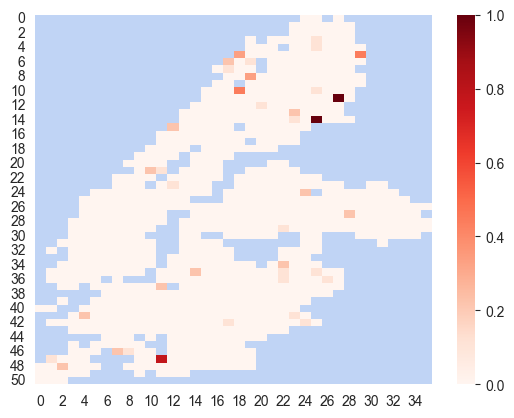

In [8]:
sns.heatmap(critical_bike_performance/len(days), mask=model.get_max_docks_in_clusters() == 0, cmap='Reds')
sns.heatmap(np.zeros([model.vertical_squares, model.horizontal_squares]), mask=model.get_max_docks_in_clusters() != 0, cbar=False, cmap='coolwarm', vmin=-1, vmax=1.5)
plt.show()

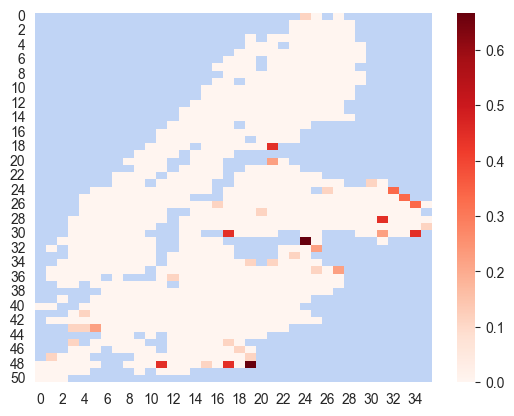

In [9]:
sns.heatmap(critical_dock_performance/len(days), mask=model.get_max_docks_in_clusters() == 0, cmap='Reds')
sns.heatmap(np.zeros([model.vertical_squares, model.horizontal_squares]), mask=model.get_max_docks_in_clusters() != 0, cbar=False, cmap='coolwarm', vmin=-1, vmax=1.5)
plt.show()

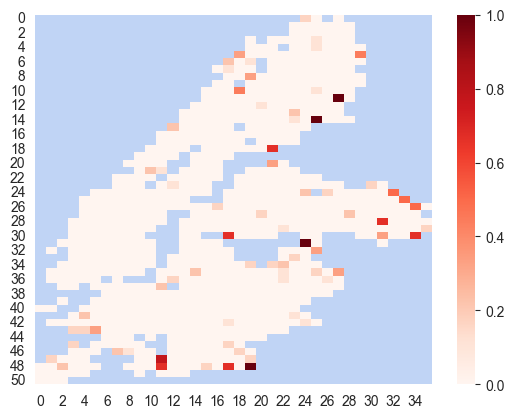

In [13]:
sns.heatmap(critical_bike_performance/len(days), cmap='Reds')
sns.heatmap(critical_dock_performance/len(days), mask=critical_dock_performance < critical_bike_performance, cmap='Reds', cbar=False)
sns.heatmap(np.zeros([model.vertical_squares, model.horizontal_squares]), mask=model.get_max_docks_in_clusters() != 0, cbar=False, cmap='coolwarm', vmin=-1, vmax=1.5)
plt.show()

In [4]:
day = 12
files = os.listdir(f'rebalancing/data/{day}')
files.sort()

df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/2024-07-10-04-00.pickle')
time_1 = '24:00'

rebalancing = {}

for i, file in enumerate(files[48:120]):
    new_df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/' + file)
    split = file[:-7].split('-')
    hours = (int(split[3])+20) % 24
    minutes = split[4]
    time_2 = str(hours) + ':' + minutes
    for reb in detect_rebalance(df, new_df, time_1, time_2):
        if reb[0] in rebalancing:
            rebalancing[reb[0]].append(reb[1:])
        else:
            rebalancing[reb[0]] = [reb[1:]]
    df = new_df
    time_1 = time_2
    


0:00 - 0:05
E 5 St & Ave C 11
0:35 - 0:40
Spruce St & Nassau St 11
0:40 - 0:45
Gold St & Frankfort St 8
0:40 - 0:45
100 St & Humphreys St -14
0:45 - 0:50
48 Ave & 5 St 76
0:45 - 0:50
100 St & Humphreys St 14
0:45 - 0:50
E 2 St & Ave B 8
0:55 - 1:00
Bailey Ave & W 229 St -15
0:55 - 1:00
Central Park West & W 85 St -24
0:55 - 1:00
W 40 St & 7 Ave 10
0:55 - 1:00
W 146 St & Broadway 8
1:00 - 1:05
Bailey Ave & W 229 St 15
1:00 - 1:05
Division Ave & Marcy Ave -17
1:00 - 1:05
Central Park West & W 85 St 26
1:00 - 1:05
6 Ave & W 33 St 10
1:05 - 1:10
Division Ave & Marcy Ave 17
1:05 - 1:10
E 63 St & 3 Ave 10
1:15 - 1:20
University Ave & W Burnside Ave 9
1:45 - 1:50
Bridge St & Water St -27
1:45 - 1:50
53 St & 4 Ave -15
1:45 - 1:50
E 43 St & 2 Ave 10
1:50 - 1:55
Bridge St & Water St 27
1:50 - 1:55
53 St & 4 Ave 15
1:55 - 2:00
3 Ave & E 169 St 10
1:55 - 2:00
Mercer St & Bleecker St -10
2:10 - 2:15
6 Ave & W 33 St 10
2:20 - 2:25
Mercer St & Spring St -10
2:20 - 2:25
Grand Concourse & E 167 St 15
2

In [5]:
print(len(rebalancing), 'Detected stations')
total = 0
remove = []
for station in rebalancing:
    total += len(rebalancing[station])
    print(station)
    summation = sum([info[0] for info in rebalancing[station]])
    print('Reb:', len(rebalancing[station]), 'Total:', summation)
    if abs(summation) < 10:
        remove.append(station)

for rm in remove:
    rebalancing.pop(rm)

48 Detected stations
E 5 St & Ave C
Reb: 1 Total: 11
Spruce St & Nassau St
Reb: 1 Total: 11
Gold St & Frankfort St
Reb: 1 Total: 8
100 St & Humphreys St
Reb: 2 Total: 0
48 Ave & 5 St
Reb: 1 Total: 76
E 2 St & Ave B
Reb: 1 Total: 8
Bailey Ave & W 229 St
Reb: 2 Total: 0
Central Park West & W 85 St
Reb: 2 Total: 2
W 40 St & 7 Ave
Reb: 1 Total: 10
W 146 St & Broadway
Reb: 1 Total: 8
Division Ave & Marcy Ave
Reb: 2 Total: 0
6 Ave & W 33 St
Reb: 3 Total: 29
E 63 St & 3 Ave
Reb: 1 Total: 10
University Ave & W Burnside Ave
Reb: 1 Total: 9
Bridge St & Water St
Reb: 3 Total: -10
53 St & 4 Ave
Reb: 10 Total: 5
E 43 St & 2 Ave
Reb: 1 Total: 10
3 Ave & E 169 St
Reb: 1 Total: 10
Mercer St & Bleecker St
Reb: 1 Total: -10
Mercer St & Spring St
Reb: 1 Total: -10
Grand Concourse & E 167 St
Reb: 1 Total: 15
W Mosholu Pkwy S & Sedgwick Ave
Reb: 2 Total: 20
W 44 St & 11 Ave
Reb: 1 Total: -8
Greene St & Prince St
Reb: 1 Total: -10
Greenwich St & Rector St
Reb: 7 Total: 12
S 4 St & Roebling St
Reb: 2 Total: 

In [6]:
rebalancing

{'E 5 St & Ave C': [[11, '0:00']],
 'Spruce St & Nassau St': [[11, '0:35']],
 '48 Ave & 5 St': [[76, '0:45']],
 'W 40 St & 7 Ave': [[10, '0:55']],
 '6 Ave & W 33 St': [[10, '1:00'], [10, '2:10'], [9, '2:30']],
 'E 63 St & 3 Ave': [[10, '1:05']],
 'Bridge St & Water St': [[-27, '1:45'], [27, '1:50'], [-10, '3:55']],
 'E 43 St & 2 Ave': [[10, '1:45']],
 '3 Ave & E 169 St': [[10, '1:55']],
 'Mercer St & Bleecker St': [[-10, '1:55']],
 'Mercer St & Spring St': [[-10, '2:20']],
 'Grand Concourse & E 167 St': [[15, '2:20']],
 'W Mosholu Pkwy S & Sedgwick Ave': [[10, '2:20'], [10, '2:25']],
 'Greene St & Prince St': [[-10, '2:45']],
 'Greenwich St & Rector St': [[-15, '3:00'],
  [16, '3:05'],
  [-23, '3:40'],
  [-14, '3:45'],
  [42, '4:15'],
  [-34, '4:35'],
  [40, '5:25']],
 'West St & Chambers St': [[-48, '3:45']],
 'Court St & Nelson St': [[-9, '4:15'], [-8, '4:20']],
 'E 16 St & Cortelyou Rd': [[-10, '4:50']],
 'Bailey Ave & W 193 St': [[11, '4:55']],
 'Cortelyou Rd & E 19 St': [[-10, '5:

1197 11
1264 11
1022 76
943 10
979 29
876 10
1340 -10
983 10
420 10
1158 -10
1157 -10
381 15
63 20
1157 -10
1262 12
1226 -48
1047 -17
1776 -10
131 11
1777 -10
382 12
943 -12


<Axes: >

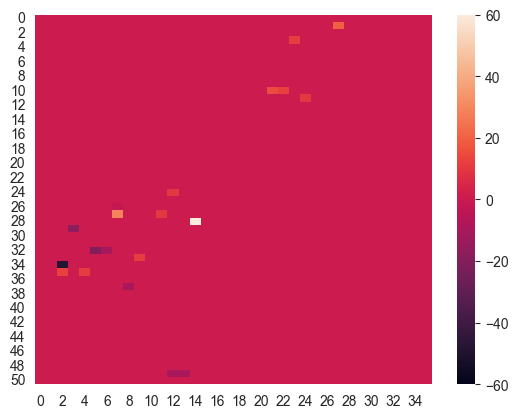

In [7]:
import seaborn as sns
for cluster in model.cluster_dict.values():
    cluster.curr_bikes = 0
for station in rebalancing:
    model.cluster_dict[model.station_clusters[station]].curr_bikes += sum([bikes[0] for bikes in rebalancing[station]])
    print(model.station_clusters[station], sum([bikes[0] for bikes in rebalancing[station]]))
sns.heatmap(model.get_num_bikes_in_clusters(), vmin=-60, vmax=60)

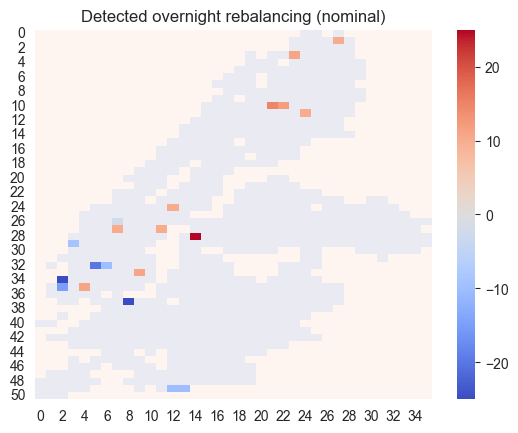

In [63]:
for cluster in model.cluster_dict.values():
    cluster.curr_bikes = 0
for station in rebalancing:
    model.cluster_dict[model.station_clusters[station]].curr_bikes += rebalancing[station][0][0]
reb = model.get_num_bikes_in_clusters()
max_docks = model.get_max_docks_in_clusters()
# temp_docks = max_docks.copy()
# temp_docks[temp_docks == 0] = 1
# reb = reb.astype(float) / temp_docks
mask_specific_color = max_docks != 0
max_docks[max_docks != 0] = 1
zero = np.zeros([model.vertical_squares, model.horizontal_squares])
sns.set_style('dark')
# sns.heatmap(zero, mask=mask_brook, cmap='Reds', cbar=False, vmin=-5, vmax=1, alpha=0.1)
sns.heatmap(reb, mask=reb==0, cmap='coolwarm', cbar=True, vmin=-25, vmax=25)
sns.heatmap(max_docks,mask=mask_specific_color, cmap='Reds', cbar=False, vmax=8)
plt.title("Detected overnight rebalancing (nominal)")
plt.show()



In [30]:
zero

NameError: name 'zero' is not defined

In [9]:
from shapely.geometry import shape
from shapely.ops import nearest_points
from shapely import Point

with open("../new-york-city-boroughs.geojson") as f:
    boroughs_geojson = simplejson.load(f)
    
def classify_borough(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in boroughs_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_borough = feature['properties']['name']
    
    return nearest_borough

boro_dict = {}
for cluster in model.cluster_dict.values():
    boro_dict[cluster.name] = classify_borough(cluster.lat, cluster.lon, boroughs_geojson)
    
clusters = []
for cluster in boro_dict:
    if boro_dict[cluster] == 'Brooklyn':
        clusters.append(cluster)

In [11]:
mask = [boro_dict[i] if i in boro_dict else 'none' for i in range(len(model.clusters))]

In [12]:
import numpy as np

mask = np.array(mask).reshape(model.vertical_squares, model_2.horizontal_squares)

In [32]:
mask_brook = mask != 'Brooklyn'

<Axes: >

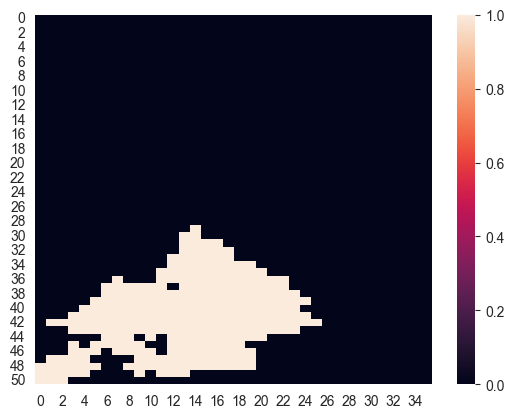

In [15]:
sns.heatmap(mask_brook)